In [7]:
import os
import re
import matplotlib.pyplot as plt

In [8]:
def extract_values(file_path, structured=True):
    obj_acc_1 = None
    rel_acc_1 = None
    triplet_acc_50 = None
    total_params = None

    with open(file_path, 'r') as file:
        for line in file:
            if "Eval: 3d obj Acc@1  :" in line:
                obj_acc_1 = float(line.split(":")[-1].strip())
            if "Eval: 3d rel Acc@1  :" in line:
                rel_acc_1 = float(line.split(":")[-1].strip())
            if "Eval: 3d triplet Acc@50 :" in line:
                triplet_acc_50 = float(line.split(":")[-1].strip())
            if structured and "Total Parameters:" in line:
                total_params = int(line.split(":")[-1].strip().replace(',', ''))
            if not structured and "Total Parameters after Unstructured pruning:" in line:
                total_params = int(line.split(":")[-1].strip().replace(',', ''))
    return obj_acc_1, rel_acc_1, triplet_acc_50, total_params

In [9]:
def process_folders(base_path, structured=True):
    results = []
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            file_path = os.path.join(folder_path, folder_path, 'result.txt')
            if os.path.isfile(file_path):
                obj_acc_1, rel_acc_1, triplet_acc_50, total_params = extract_values(file_path, structured)
                if obj_acc_1 is not None and rel_acc_1 is not None and triplet_acc_50 is not None and total_params is not None:
                    if 'baseline' in folder_name:
                        ratio = 0
                    else:
                        ratio = re.search(r'st(\d+)', folder_name)
                        if ratio:
                            ratio = int(ratio.group(1)) / 100
                    results.append((ratio, obj_acc_1, rel_acc_1, triplet_acc_50, total_params))
    return results

In [10]:
def plot_results(title, structured_results, unstructured_results, additional_structured_results, additional_unstructured_results):
    structured_results.sort()
    unstructured_results.sort()
    additional_structured_results.sort()
    additional_unstructured_results.sort()

    fig, axs = plt.subplots(3, 1, figsize=(10, 18))
    
    # Baseline 값 찾기 및 분리
    baseline_structured = [result for result in structured_results if result[0] == 0]
    baseline_unstructured = [result for result in unstructured_results if result[0] == 0]

    # Baseline을 제외한 나머지 structured 결과
    structured_results = [result for result in structured_results if result[0] != 0]
    unstructured_results = [result for result in unstructured_results if result[0] != 0]

    if structured_results:
        struct_ratios, struct_obj_accs, struct_rel_accs, struct_triplet_accs, _ = zip(*structured_results)
    else:
        struct_ratios, struct_obj_accs, struct_rel_accs, struct_triplet_accs = [], [], [], []

    if unstructured_results:
        unstruct_ratios, unstruct_obj_accs, unstruct_rel_accs, unstruct_triplet_accs, _ = zip(*unstructured_results)
    else:
        unstruct_ratios, unstruct_obj_accs, unstruct_rel_accs, unstruct_triplet_accs = [], [], [], []

    if additional_structured_results:
        add_struct_ratios, add_struct_obj_accs, add_struct_rel_accs, add_struct_triplet_accs = zip(*additional_structured_results)
    else:
        add_struct_ratios, add_struct_obj_accs, add_struct_rel_accs, add_struct_triplet_accs = [], [], [], []

    if additional_unstructured_results:
        add_unstruct_ratios, add_unstruct_obj_accs, add_unstruct_rel_accs, add_unstruct_triplet_accs = zip(*additional_unstructured_results)
    else:
        add_unstruct_ratios, add_unstruct_obj_accs, add_unstruct_rel_accs, add_unstruct_triplet_accs = [], [], [], []

    # Obj Acc@1 그리기
    axs[0].set_title('3d obj Acc@1')
    axs[0].set_xlabel('Pruning Ratio')
    axs[0].set_ylabel('Acc@1')
    axs[0].grid(True)
    axs[0].set_xticks([i/100 for i in range(0, 101, 5)])

    if baseline_structured:
        _, baseline_acc, _, _, _ = baseline_structured[0]
        axs[0].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[0].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if baseline_unstructured:
        _, baseline_acc, _, _, _ = baseline_unstructured[0]
        axs[0].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[0].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if structured_results:
        axs[0].plot(struct_ratios, struct_obj_accs, marker='o', linestyle='-', label='Structured Pruning', color='#6C946F')

    if additional_structured_results:
        axs[0].plot(add_struct_ratios, add_struct_obj_accs, marker='*', linestyle='--', label='Structured Pruning + Fine-tuning', color='#6C946F')
        for ratio, acc in zip(add_struct_ratios, add_struct_obj_accs):
            axs[0].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    if unstructured_results:
        axs[0].plot(unstruct_ratios, unstruct_obj_accs, marker='o', linestyle='-', label='Unstructured Pruning', color='#DC0083')

    if additional_unstructured_results:
        axs[0].plot(add_unstruct_ratios, add_unstruct_obj_accs, marker='*', linestyle='--', label='Unstructured Pruning + Fine-tuning', color='#DC0083')
        for ratio, acc in zip(add_unstruct_ratios, add_unstruct_obj_accs):
            axs[0].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    axs[0].legend()

    # Rel Acc@1 그리기
    axs[1].set_title('3d rel Acc@1')
    axs[1].set_xlabel('Pruning Ratio')
    axs[1].set_ylabel('Acc@1')
    axs[1].grid(True)
    axs[1].set_xticks([i/100 for i in range(0, 101, 5)])

    if baseline_structured:
        _, _, baseline_acc, _, _ = baseline_structured[0]
        axs[1].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[1].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if baseline_unstructured:
        _, _, baseline_acc, _, _ = baseline_unstructured[0]
        axs[1].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[1].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if structured_results:
        axs[1].plot(struct_ratios, struct_rel_accs, marker='o', linestyle='-', label='Structured Pruning', color='#6C946F')

    if additional_structured_results:
        axs[1].plot(add_struct_ratios, add_struct_rel_accs, marker='*', linestyle='--', label='Structured Pruning + Fine-tuning', color='#6C946F')
        for ratio, acc in zip(add_struct_ratios, add_struct_rel_accs):
            axs[1].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    if unstructured_results:
        axs[1].plot(unstruct_ratios, unstruct_rel_accs, marker='o', linestyle='-', label='Unstructured Pruning', color='#DC0083')

    if additional_unstructured_results:
        axs[1].plot(add_unstruct_ratios, add_unstruct_rel_accs, marker='*', linestyle='--', label='Unstructured Pruning + Fine-tuning', color='#DC0083')
        for ratio, acc in zip(add_unstruct_ratios, add_unstruct_rel_accs):
            axs[1].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    axs[1].legend()

    # Triplet Acc@50 그리기
    axs[2].set_title('3d triplet Acc@50')
    axs[2].set_xlabel('Pruning Ratio')
    axs[2].set_ylabel('Acc@50')
    axs[2].grid(True)
    axs[2].set_xticks([i/100 for i in range(0, 101, 5)])

    if baseline_structured:
        _, _, _, baseline_acc, _ = baseline_structured[0]
        axs[2].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[2].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if baseline_unstructured:
        _, _, _, baseline_acc, _ = baseline_unstructured[0]
        axs[2].scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        axs[2].text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if structured_results:
        axs[2].plot(struct_ratios, struct_triplet_accs, marker='o', linestyle='-', label='Structured Pruning', color='#6C946F')

    if additional_structured_results:
        axs[2].plot(add_struct_ratios, add_struct_triplet_accs, marker='*', linestyle='--', label='Structured Pruning + Fine-tuning', color='#6C946F')
        for ratio, acc in zip(add_struct_ratios, add_struct_triplet_accs):
            axs[2].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    if unstructured_results:
        axs[2].plot(unstruct_ratios, unstruct_triplet_accs, marker='o', linestyle='-', label='Unstructured Pruning', color='#DC0083')

    if additional_unstructured_results:
        axs[2].plot(add_unstruct_ratios, add_unstruct_triplet_accs, marker='*', linestyle='--', label='Unstructured Pruning + Fine-tuning', color='#DC0083')
        for ratio, acc in zip(add_unstruct_ratios, add_unstruct_triplet_accs):
            axs[2].text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    axs[2].legend()

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

Structured - Pruning Ratio: 0.35, Eval: 3d obj Acc@1: 47.60800842992624, Eval: 3d rel Acc@1: 65.28679787814188, Eval: 3d triplet Acc@50: 86.21783748946507
Structured - Pruning Ratio: 0.55, Eval: 3d obj Acc@1: 37.36564805057956, Eval: 3d rel Acc@1: 52.88037281245352, Eval: 3d triplet Acc@50: 80.1249318328293
Structured - Pruning Ratio: 0.75, Eval: 3d obj Acc@1: 16.90200210748156, Eval: 3d rel Acc@1: 63.38059590501214, Eval: 3d triplet Acc@50: 74.65668534034009
Structured - Pruning Ratio: 0.2, Eval: 3d obj Acc@1: 53.04531085353003, Eval: 3d rel Acc@1: 81.12141192801546, Eval: 3d triplet Acc@50: 88.34465321501165
Structured - Pruning Ratio: 0.7, Eval: 3d obj Acc@1: 24.488935721812435, Eval: 3d rel Acc@1: 56.658073471815975, Eval: 3d triplet Acc@50: 75.56392841207675
Structured - Pruning Ratio: 0.1, Eval: 3d obj Acc@1: 54.836670179135936, Eval: 3d rel Acc@1: 86.54008229636607, Eval: 3d triplet Acc@50: 89.06102820881463
Structured - Pruning Ratio: 0.3, Eval: 3d obj Acc@1: 49.020021074815595

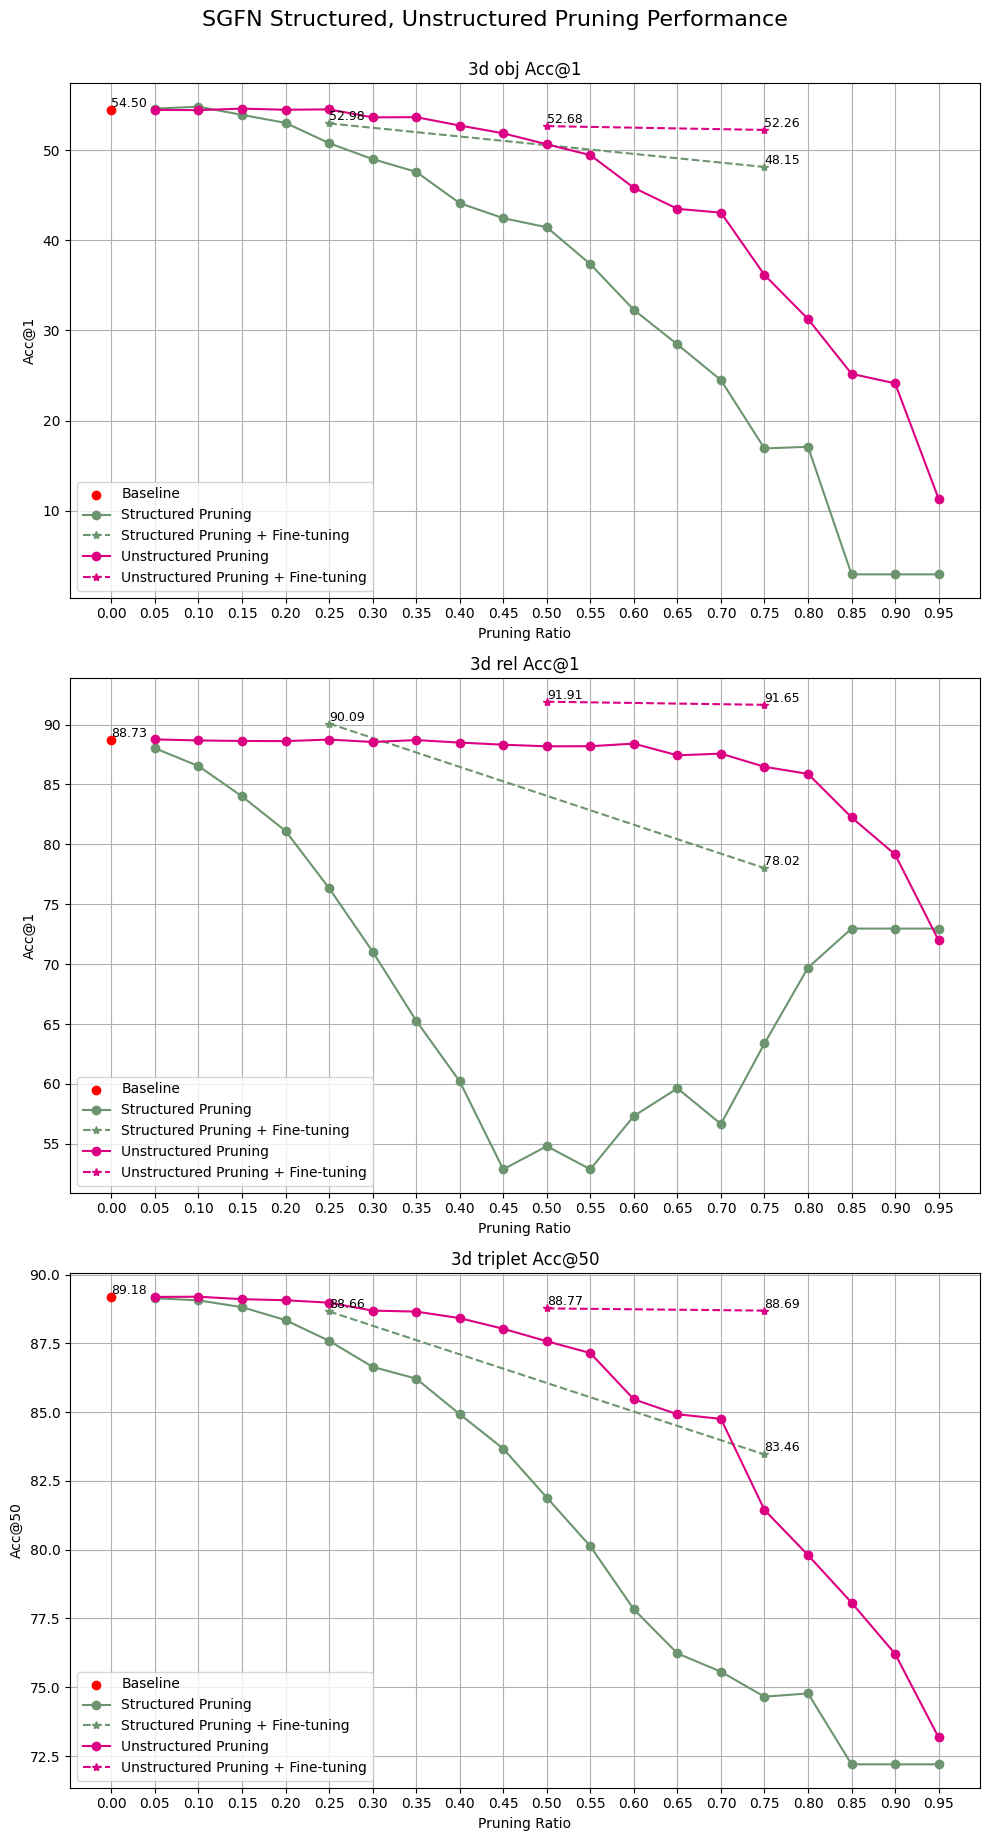

In [11]:
title = 'SGFN Structured, Unstructured Pruning Performance'
base_path_structured = '/home/oi/Desktop/song/lightweight_3DSSG/config/results/sgfn/eval_sgfn_st'  # 여기에 실제 구조화된 폴더 경로를 넣으세요
base_path_unstructured = '/home/oi/Desktop/song/lightweight_3DSSG/config/results/sgfn/eval_sgfn_unst'  # 여기에 실제 비구조화된 폴더 경로를 넣으세요

structured_results = process_folders(base_path_structured, structured=True)
unstructured_results = process_folders(base_path_unstructured, structured=False)

#추가 학습 후 결과 직접 입력 (구조화된 및 비구조화된)
additional_structured_results = [
    (0.25, 52.98, 90.09, 88.66),  # (Pruning Ratio, obj Acc@1, rel Acc@1, triplet Acc@50)
    #(0.50, 86.89, 87.92, 87.89),
    (0.75, 48.15, 78.02, 83.46)
]
additional_unstructured_results = [
    #(0.25, 86.41, 87.51, 88.41),  # (Pruning Ratio, obj Acc@1, rel Acc@1, triplet Acc@50)
    (0.50, 52.68, 91.91, 88.77),
    (0.75, 52.26, 91.65, 88.69)
]

for ratio, obj_acc_1, rel_acc_1, triplet_acc_50, _ in structured_results:
    print(f"Structured - Pruning Ratio: {ratio}, Eval: 3d obj Acc@1: {obj_acc_1}, Eval: 3d rel Acc@1: {rel_acc_1}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, obj_acc_1, rel_acc_1, triplet_acc_50, _ in unstructured_results:
    print(f"Unstructured - Pruning Ratio: {ratio}, Eval: 3d obj Acc@1: {obj_acc_1}, Eval: 3d rel Acc@1: {rel_acc_1}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, obj_acc_1, rel_acc_1, triplet_acc_50 in additional_structured_results:
    print(f"Additional Structured Training - Pruning Ratio: {ratio}, Eval: 3d obj Acc@1: {obj_acc_1}, Eval: 3d rel Acc@1: {rel_acc_1}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, obj_acc_1, rel_acc_1, triplet_acc_50 in additional_unstructured_results:
    print(f"Additional Unstructured Training - Pruning Ratio: {ratio}, Eval: 3d obj Acc@1: {obj_acc_1}, Eval: 3d rel Acc@1: {rel_acc_1}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

plot_results(title, structured_results, unstructured_results, additional_structured_results, additional_unstructured_results)

In [6]:
def plot_structured_results(title, structured_results):
    structured_results.sort()
    baseline_structured = [result for result in structured_results if result[0] == 0]
    structured_results = [result for result in structured_results if result[0] != 0]
    # Extract data for plotting
    if structured_results:
        struct_ratios, struct_obj_accs, struct_rel_accs, struct_triplet_accs, struct_params = zip(*structured_results)
    else:
        struct_ratios, struct_obj_accs, struct_rel_accs, struct_triplet_accs = [], [], [], []

    fig, axs = plt.subplots(3, 1, figsize=(10, 18), tight_layout=True)
    
    if structured_results:
        axs[2].plot(struct_ratios, struct_triplet_accs, marker='o', linestyle='-', label='Structured Pruning', color='#6C946F')
    # Plot 3d obj Acc@1
    axs[0].set_title('3D Object Accuracy (Acc@1)')
    axs[0].set_xlabel('Pruning Ratio')
    axs[0].set_ylabel('Acc@1')
    axs[0].plot(struct_ratios, struct_obj_accs, marker='o', linestyle='-', color='#6C946F', label='Structured Pruning')
    axs[0].set_xticks([i/100 for i in range(0, 75, 5)])
    axs[0].grid(True)
    axs[0].legend()

    # Plot 3d rel Acc@1
    axs[1].set_title('3D Relation Accuracy (Acc@1)')
    axs[1].set_xlabel('Pruning Ratio')
    axs[1].set_ylabel('Acc@1')
    axs[1].plot(struct_ratios, struct_rel_accs, marker='o', linestyle='-', color='#6C946F', label='Structured Pruning')
    axs[1].set_xticks([i/100 for i in range(0, 75, 5)])
    axs[1].grid(True)
    axs[1].legend()

    # Plot 3d triplet Acc@50
    axs[2].set_title('3D Triplet Accuracy (Acc@50)')
    axs[2].set_xlabel('Pruning Ratio')
    axs[2].set_ylabel('Acc@50')
    axs[2].plot(struct_ratios, struct_triplet_accs, marker='o', linestyle='-', color='#6C946F', label='Structured Pruning')
    axs[2].set_xticks([i/100 for i in range(0, 75, 5)])
    axs[2].grid(True)
    axs[2].legend()

    # Highlight baseline if it exists
    if baseline_structured:
        for i in range(3):
            baseline_acc = baseline_structured[0][i+1]
            axs[i].scatter(0, baseline_acc, color='red', zorder=5)
            axs[i].text(0, baseline_acc, f'Baseline: {baseline_acc:.2f}%', fontsize=9, verticalalignment='bottom')

    plt.suptitle(title, fontsize=16)
    plt.show()

Structured - Pruning Ratio: 0.55, Eval: 3d obj Acc@1: 45.395152792413064, Eval: 3d rel Acc@1: 73.86594616032919, Eval: 3d triplet Acc@50: 83.12180853700858
Structured - Pruning Ratio: 0.35, Eval: 3d obj Acc@1: 54.604847207586936, Eval: 3d rel Acc@1: 74.50299935551038, Eval: 3d triplet Acc@50: 87.88359526052253
Structured - Pruning Ratio: 0.5, Eval: 3d obj Acc@1: 49.82086406743941, Eval: 3d rel Acc@1: 73.10247384859451, Eval: 3d triplet Acc@50: 85.18913291358882
Structured - Pruning Ratio: 0.1, Eval: 3d obj Acc@1: 54.373024236037935, Eval: 3d rel Acc@1: 85.12220514600169, Eval: 3d triplet Acc@50: 89.20727777502354
Structured - Pruning Ratio: 0.2, Eval: 3d obj Acc@1: 54.58377239199157, Eval: 3d rel Acc@1: 73.1247831044569, Eval: 3d triplet Acc@50: 88.68672847156809
Structured - Pruning Ratio: 0.3, Eval: 3d obj Acc@1: 54.64699683877766, Eval: 3d rel Acc@1: 74.58727876654604, Eval: 3d triplet Acc@50: 88.30994992811462
Structured - Pruning Ratio: 0.45, Eval: 3d obj Acc@1: 53.50895679662803,

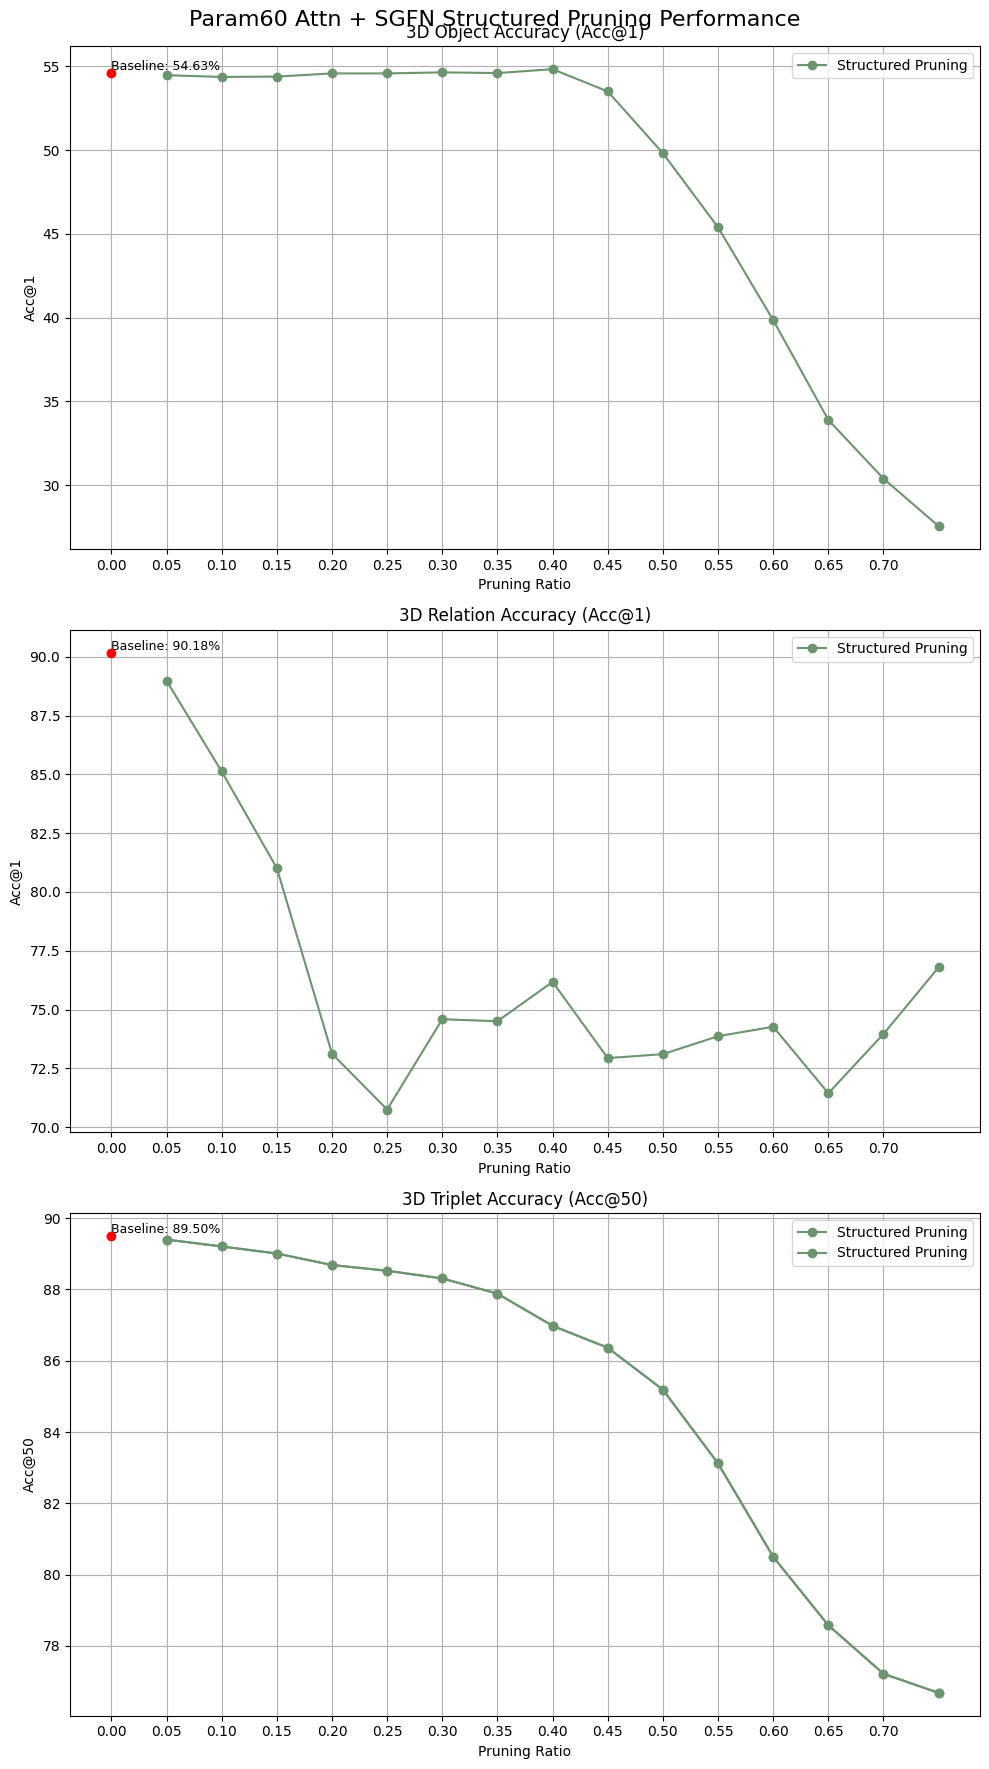

In [30]:
title = 'Param60 Attn + SGFN Structured Pruning Performance'
base_path_structured = '/home/oi/Desktop/song/lightweight_3DSSG/config/results/sgfn/eval_param60_attnSGFN_st'  # 여기에 실제 구조화된 폴더 경로를 넣으세요

structured_results = process_folders(base_path_structured, structured=True)

for ratio, obj_acc_1, rel_acc_1, triplet_acc_50, _ in structured_results:
    print(f"Structured - Pruning Ratio: {ratio}, Eval: 3d obj Acc@1: {obj_acc_1}, Eval: 3d rel Acc@1: {rel_acc_1}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

plot_structured_results(title, structured_results)